### Script to overlay AOD-500nmTotal and Wind Vector on the same plot.

### Make sure both the AERONET and Wind data files are in the right place and the Start and End Dates are within the dataset you're looking at.

Modesto
Index(['AOD_1640nm-Total', 'AOD_1020nm-Total', 'AOD_870nm-Total',
       'AOD_865nm-Total', 'AOD_779nm-Total', 'AOD_675nm-Total',
       'AOD_667nm-Total', 'AOD_620nm-Total', 'AOD_560nm-Total',
       'AOD_555nm-Total', 'AOD_551nm-Total', 'AOD_532nm-Total',
       'AOD_531nm-Total', 'AOD_510nm-Total', 'AOD_500nm-Total',
       'AOD_490nm-Total', 'AOD_443nm-Total', 'AOD_440nm-Total',
       'AOD_412nm-Total', 'AOD_400nm-Total', 'AOD_380nm-Total',
       'AOD_340nm-Total'],
      dtype='object') 	Size:  22
The Wavelength  AOD_1640nm-Total has the largest number of weekly entries at  349  entries.
Dropped  45  NaN entries from  AOD_1640nm-Total
Dropped  1  NaN entries from  AOD_1020nm-Total
Dropped  1  NaN entries from  AOD_870nm-Total
Dropped  0  NaN entries from  AOD_675nm-Total
Dropped  4  NaN entries from  AOD_500nm-Total
Dropped  3  NaN entries from  AOD_440nm-Total
Dropped  5  NaN entries from  AOD_380nm-Total
Dropped  21  NaN entries from  AOD_340nm-Total


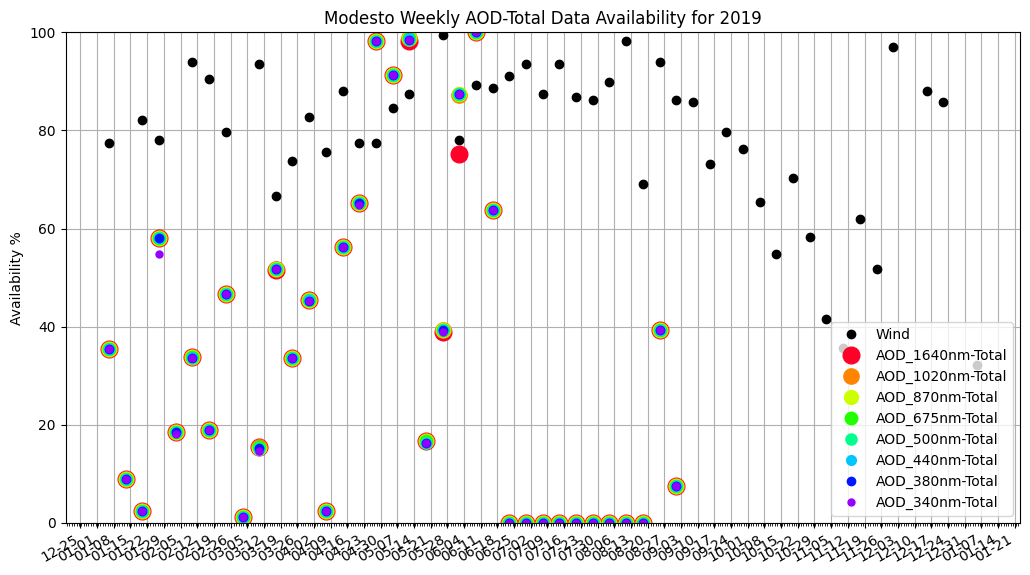

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import csv

filename = 'AERONET_Data/20190101_20191231_Modesto.tot_lev20'
windfile = 'Wind_Data/Modesto_Wind_2019_Jan_Dec_72492623258.csv'
StartDate='2016-01-01 00:00:00'
EndDate='2023-12-31 23:59:59'

# Getting the name of the site
with open(filename) as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader) # The first line 
    for line in csvreader:
        siteName = line[0]
        break
print(siteName)

# Load the AERONET data and make US/PAC time its index.
df = pd.read_csv(filename,skiprows = 6, parse_dates={'datetime':[0,1]})
datetime_utc=pd.to_datetime(df["datetime"], format='%d:%m:%Y %H:%M:%S')
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df.set_index(datetime_pac, inplace = True)

# Load NOAA data and make US/PAC time its index.
# Wdf = Weather Data Frame
Wdf = pd.read_csv(windfile, parse_dates={'datetime':[1]}, low_memory=False)
datetime_utc=pd.to_datetime(Wdf["datetime"], format='%d-%m-%Y %H:%M:%S')
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
Wdf.set_index(datetime_pac, inplace = True)
# Note that we're making a copy of Wdf as WNDdf (Wind Dataframe)
WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
## Cut on the Data that has both Valid Windspeed and Direction.
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf= WNDdf.loc[WNDdf[1]=='5']

# Set the Columns that has the AOD Total and replace -999 with nan in all AOD_Total wavelengths.
AODTotalColumns=range(3,173,8)
for iWaveLength in df.columns[AODTotalColumns]:
    df[iWaveLength].replace(-999.0, np.nan, inplace = True)
#for iWaveLength in df.columns[AODTotalColumns]: print(iWaveLength) #Print out the List of Wavelength with AOD Total

# Creating Graphs for plotting the availablity of data
print(df.columns[AODTotalColumns], '\tSize: ', len(df.columns[AODTotalColumns]))
largest = [0, '']
for i in df.columns[AODTotalColumns]:
    if(df[i].mean() > 0):
        if df.loc[StartDate:EndDate, iWaveLength].dropna().groupby([pd.Grouper(freq='W')]).size().max() > largest[0]:
            largest[0], largest[1] = df.loc[StartDate:EndDate, iWaveLength].dropna().groupby([pd.Grouper(freq='W')]).size().max(), i
print('The Wavelength ', largest[1], 'has the largest number of weekly entries at ', largest[0], ' entries.') # 349
ax = plt.figure(figsize=(16*.65,9*.65)).add_subplot(111) # 16:9 resolution scaled down to 65%
ax.set_title(siteName + ' Weekly AOD-Total Data Availability for ' + filename[13:17])

## Dynamically Adjusting Colors to increase the potential number of colors usable in the graph
### This should allow for all of the colors of the rainbow to be used, the higher number of valid wavelengths in our dataset, the more colors will be selected
### Note: The colors do not necessarily follow what their actual wavelengths are
vaildWavelengthsCount = 0
for i in df.columns[AODTotalColumns]:
    if(df[i].mean() > 0):
        vaildWavelengthsCount += 1
cm = plt.get_cmap('gist_rainbow') # Color Mapping
ax.set_prop_cycle(color=[cm(1.*i/vaildWavelengthsCount) for i in range(vaildWavelengthsCount)]) # Setting the color scheme to rainbow colors

## Adding the plots the graph
count, handlesList = 0, []
### Comment out the next four lines to show only the AOD Data
dfGroup = WNDdf.loc[StartDate:EndDate, 1].dropna().groupby([pd.Grouper(freq='W')]).size()
wind = ax.plot(dfGroup[dfGroup <= 24*7]/(24*7)*100, '.', label='Wind', markersize=vaildWavelengthsCount*1.5, c='k')
handlesList.append(wind[0])
ax.plot(dfGroup[dfGroup > 24*7]/(24*7)*100, '.', label='Wind', markersize=vaildWavelengthsCount*1.5, c='k')

for iWaveLength in df.columns[AODTotalColumns]: 
    if(df[iWaveLength].mean() > 0):
        dfGroup = df.loc[StartDate:EndDate, iWaveLength].dropna().groupby([pd.Grouper(freq='W')]).size()
        dots = ax.plot(dfGroup[dfGroup <= 4*12*7]/(4*12*7)*100,'.',label=iWaveLength, markersize=vaildWavelengthsCount*3-count*2) # Excluding entries that will go above our 100% scale
        handlesList.append(dots[0])
        ax.plot(dfGroup[dfGroup > 4*12*7]/dfGroup[dfGroup > 4*12*7]*100,'.', markersize=vaildWavelengthsCount*3-count*2, c=dots[0].get_color()) # Placing entries with more than 100% availability on the 100% line
        print('Dropped ', len(df.loc[StartDate:EndDate, iWaveLength])-len(df.loc[StartDate:EndDate, iWaveLength].dropna()), ' NaN entries from ', iWaveLength)
        count += 1

## Formatting the graph
plt.gcf().autofmt_xdate()
plt.grid(which='major',axis='both')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=24, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0,100)
plt.ylabel('Availability %')
plt.legend(handles=handlesList, loc='best')
plt.tight_layout()

## Optional, saving the plot to a file as a .png.
### Note: You must save the plot before calling plt.show(), additionally, you must have the relative directory setup otherwise this will produce a "soft" error.
### Change 'False' in the if-statement to True to enable saving the plot as a png
if False:
    filename = siteName + '_' + filename[13:17] + '_' + str(pd.Timestamp.now().strftime('%Y-%m-%d_%H%M%S'))# + StartDate + '_' + EndDate
    location = 'graphs\\availability\\' + filename
    plt.savefig(location) # Saves the plot to a .png file.

plt.show()

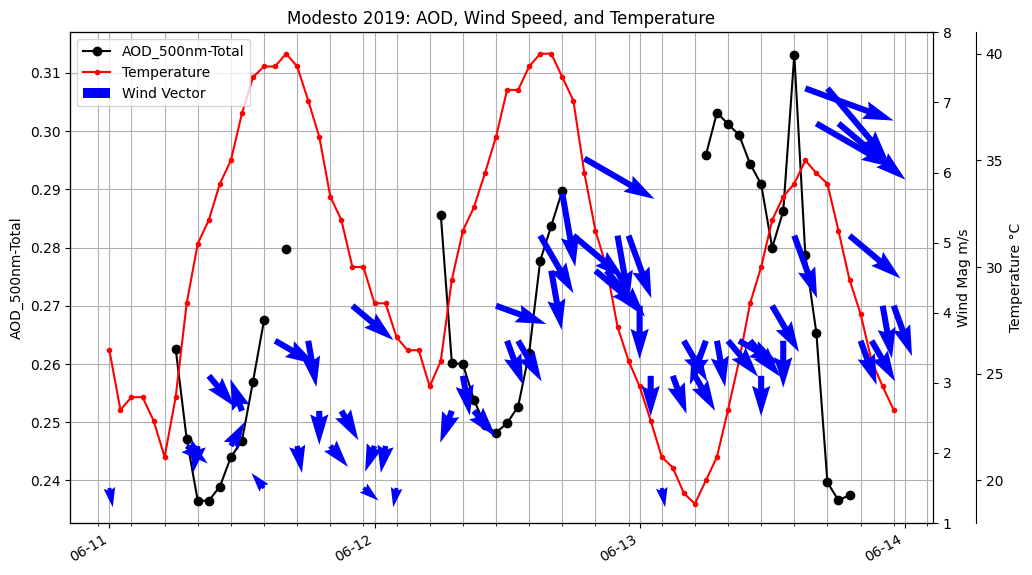

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

filename = 'AERONET_Data/20190101_20191231_Modesto.tot_lev20'
windfile = 'Wind_Data/Modesto_Wind_2019_Jan_Dec_72492623258.csv'
weatherFile = 'Wind_Data/Modesto_Weather_Feb_2019.csv'
StartDate='2019-06-11 00:00:00'
EndDate='2019-06-13 23:59:59'
sampleRate = '1h'
windSampleRate = sampleRate

# Load the AERONET data and make US/PAC time its index.
df = pd.read_csv(filename,skiprows = 6, parse_dates={'datetime':[0,1]})
datetime_utc=pd.to_datetime(df["datetime"], format='%d:%m:%Y %H:%M:%S')
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df.set_index(datetime_pac, inplace = True)

# Set the Columns that has the AOD Total and replace -999 with nan in visible wavelengths.
AODTotalColumns=range(3,173,8)
#for iWaveLength in df.columns[AODTotalColumns]: print(iWaveLength)
#Replaces all -999 values with nan so invalid entries does not affect resample.mean()
df['AOD_380nm-Total'].replace(-999.0, np.nan, inplace = True)
df['AOD_440nm-Total'].replace(-999.0, np.nan, inplace = True)
df['AOD_500nm-Total'].replace(-999.0, np.nan, inplace = True)
df['AOD_675nm-Total'].replace(-999.0, np.nan, inplace = True)
    
# Load NOAA data and make US/PAC time its index.
# Wdf = Weather Data Frame
Wdf = pd.read_csv(windfile, parse_dates={'datetime':[1]}, low_memory=False)
datetime_utc=pd.to_datetime(Wdf["datetime"], format='%d-%m-%Y %H:%M:%S')
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
Wdf.set_index(datetime_pac, inplace = True)
# Note that we're making a copy of Wdf as WNDdf (Wind Dataframe)
WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
## Cut on the Data that has both Valid Windspeed and Direction.
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf= WNDdf.loc[WNDdf[1]=='5']

# Converting the Cardinal Coordinates to Cartesian using x=r*sinΘ and y=r*cosΘ
Xdata, Ydata = [], []
for _, row in WNDdf.iterrows():
    Xdata.append(np.float64(row[3]) # Magnitude
                 *np.sin(np.float64(row[0]) # Angle
                               *(np.pi/180)))
    Ydata.append(np.float64(row[3])*np.cos(np.float64(row[0])*(np.pi/180)))
WNDdf[5], WNDdf[6] = Xdata, Ydata # Appending these new Coordinates to the Wind Data Frame

# Tdf = Temperature Data Frame
## Splitting Temperature from the Weather Data Frame and expanding the string into individual columns
Tdf = Wdf.loc[StartDate:EndDate,'TMP'].str.split(pat=',', expand = True)
## Replacing +9999 values with nan, +9999 indicates "missing data"
Tdf.replace('+9999', np.nan, inplace = True)

# Creating Figure and main Axis
## Note: Technically, we can draw multiple, side-by-side, graphs using this method.
## Using a 16x9 aspect ratio
fig, axes = plt.subplots(1,1, figsize=(16*.65,9*.65)) # plt.subplots(nrows, ncolumns, *args) # axs will be either an individual plot or an array of axes
try:
    ax = axes[0,0] # If axes is a 2D array of axes, then we'll use the first axis for this drawing.
except:
    try:
        ax = axes[0] # If axes is a 1D array of axes, then we'll use the first axis for this drawing.
    except:
        ax = axes # If axes is just a single axis then we'll use it directly.

# Initializing main Axis and plot
fig.autofmt_xdate() ## Note: With multiple plots, this removes the x-axis identifiers for plots not in the bottom row 
ax.set_title("Modesto 2019: AOD, Wind Speed, and Temperature")
ax.grid(which='both',axis='both')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Drawing the first pieces of data (AOD_500nm-Total) onto the graph
ax.set_ylabel("AOD_500nm-Total")
plot1, = ax.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample(sampleRate).mean(),'ok-',label='AOD_500nm-Total', figure=fig) # handle, label = ax.plot()

# Adding a new Axis sharing the same xaxis as before and drawing the second piece of data.
ax2 = ax.twinx()
ax2.spines.right.set_position(('axes', 1.05)) # Adjusting the position of the "spine" or y-axis to not overlap with the next pieces of data
ax2.set_ylabel('Temperature °C')
ax2.set_ylim(Tdf[0].loc[StartDate:EndDate].astype(float).resample(sampleRate).mean().div(10).min()//-1,Tdf[0].loc[StartDate:EndDate].astype(float).resample(sampleRate).mean().div(10).max()//1) # Auto Calculating
ax2.set_ylim(18,41) # Manual Setting
plot2, = ax2.plot(Tdf[0].loc[StartDate:EndDate].astype(float).resample(sampleRate).mean().div(10), '.r-',label='Temperature',figure=fig) # handle, label = ax2.plot()

# Adding a new Axis sharing the same xaxis as the previous two and drawing the thrid piece of data
ax3 = ax.twinx()
#ax3.spines.right.set_position(('axes', 1)) # Adjusting the position of the "spine" or y-axis (Only needed if we want to move this y-axis)
ax3.set_ylabel("Wind Mag m/s")
ax3.set_ylim(WNDdf[3].loc[StartDate:EndDate].astype(float).div(10).min()//1, WNDdf[3].loc[StartDate:EndDate].astype(float).div(10).max()//1) # Auto Calculating
ax3.set_ylim(1,8) # Manual Setting
plot3 = ax3.quiver(WNDdf[5].resample(windSampleRate).mean().index,
                   np.sqrt( (WNDdf[5].loc[StartDate:EndDate].astype(float).resample(windSampleRate).sum() / 
                WNDdf.loc[StartDate:EndDate].resample(windSampleRate).size())**2 + 
                (WNDdf[6].loc[StartDate:EndDate].astype(float).resample(windSampleRate).sum() / 
                WNDdf.loc[StartDate:EndDate].resample(windSampleRate).size())**2
                )/10,
                -WNDdf[5].loc[StartDate:EndDate].astype(float).resample(windSampleRate).mean().div(10), 
                -WNDdf[6].loc[StartDate:EndDate].astype(float).resample(windSampleRate).mean().div(10),
                color='b',label='Wind Vector')

#testString = 'Temperature: ' + str(Tdf[0].loc[StartDate:EndDate].astype(float).resample(sampleRate).mean().div(10).max()//1) + '/' + str(Tdf[0].loc[StartDate:EndDate].astype(float).resample(sampleRate).mean().div(10).min()//1) + '\nPercipiation: ' + str(5)
#ax.text(0.5, 0.5, testString, transform=ax.transAxes, fontsize=10, bbox= dict(boxstyle='round', facecolor='cyan', alpha=0.5))

# Displaying the legend and Reorganizing everything to fit nicely
## Note: plot1 and plot2 are the handles for the data we created and plot3, the quiver, is handled differently.
plt.legend(handles = [plot1, plot2, plot3], loc = 'best')
plt.tight_layout() # Adjusts the boundaries of the figures to ensure everything fits nicely. Can define pads as we we see fit. 
# Example: plt.tight_layout(pad=n, h_pad=n2, w_pad=n3, rect=tuple) where n# are floats and tuple is a tubple of integers (0,0,1,1)

# Optional, saving the plot to a file as a .png.
## Note: You must save the plot before calling plt.show(), additionally, you must have the relative directory setup otherwise this will produce a "soft" error.
## Change 'False' in the if-statement to True to enable saving the plot as a png
if False:
    filename = 'Modesto_' + str(pd.Timestamp.now().strftime('%Y-%m-%d_%H%M%S'))# + StartDate + '_' + EndDate
    location = 'graphs\\Modesto 2019\\' + filename
    plt.savefig(location) # Saves the plot to a .png file.

plt.show()

# Additional Info/Links:
# https://matplotlib.org/2.0.2/users/recipes.html # ← Contains Additional information on useful plotting techniques
# https://matplotlib.org/3.4.3/gallery/ticks_and_spines/multiple_yaxis_with_spines.html # ← Use this format for graph handling


In [10]:
#print(np.arange(49))
WNDdf


,0,1,2,3,4,5,6
datetime,,,,,,,
2019-06-11 00:53:00-07:00,350,5,N,0015,5,-2.604723e+00,14.772116
2019-06-11 07:53:00-07:00,310,5,N,0021,5,-1.608693e+01,13.498540
2019-06-11 08:53:00-07:00,010,5,N,0021,5,3.646612e+00,20.680963
2019-06-11 09:53:00-07:00,320,5,N,0031,5,-1.992642e+01,23.747378
2019-06-11 11:53:00-07:00,210,5,N,0021,5,-1.050000e+01,-18.186533
2019-06-11 12:53:00-07:00,160,5,N,0026,5,8.892524e+00,-24.432008
2019-06-11 14:53:00-07:00,140,5,N,0015,5,9.641814e+00,-11.490667
2019-06-11 15:53:00-07:00,300,5,N,0036,5,-3.117691e+01,18.000000
2019-06-11 17:53:00-07:00,350,5,N,0021,5,-3.646612e+00,20.680963


### Let's open the Turlock AOD 1.5 Data. The 1.5 does not have a quality check on them compared to 2.0.

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

filename = 'AERONET_Data/20230101_20231231_Turlock_CA_USA.tot_lev15'

# Load Files 
df = pd.read_csv(filename,skiprows = 6, parse_dates={'datetime':[0,1]})
datetime_utc=pd.to_datetime(df["datetime"], format='%d:%m:%Y %H:%M:%S')
#print(datetime_pac.head())
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
#print(datetime_pac.head())

df.set_index(datetime_pac, inplace = True)
df.replace(-999.0, np.nan, inplace = True)
#print(df.head())  

AODTotalColumns=range(3,173,8)
for iWaveLength in df.columns[AODTotalColumns]: print(iWaveLength) #Print out the List of Wavelength with AOD Total


AOD_1640nm-Total
AOD_1020nm-Total
AOD_870nm-Total
AOD_865nm-Total
AOD_779nm-Total
AOD_675nm-Total
AOD_667nm-Total
AOD_620nm-Total
AOD_560nm-Total
AOD_555nm-Total
AOD_551nm-Total
AOD_532nm-Total
AOD_531nm-Total
AOD_510nm-Total
AOD_500nm-Total
AOD_490nm-Total
AOD_443nm-Total
AOD_440nm-Total
AOD_412nm-Total
AOD_400nm-Total
AOD_380nm-Total
AOD_340nm-Total


### Now let's make a plot of all the AOD Total for Different Wavelengths.

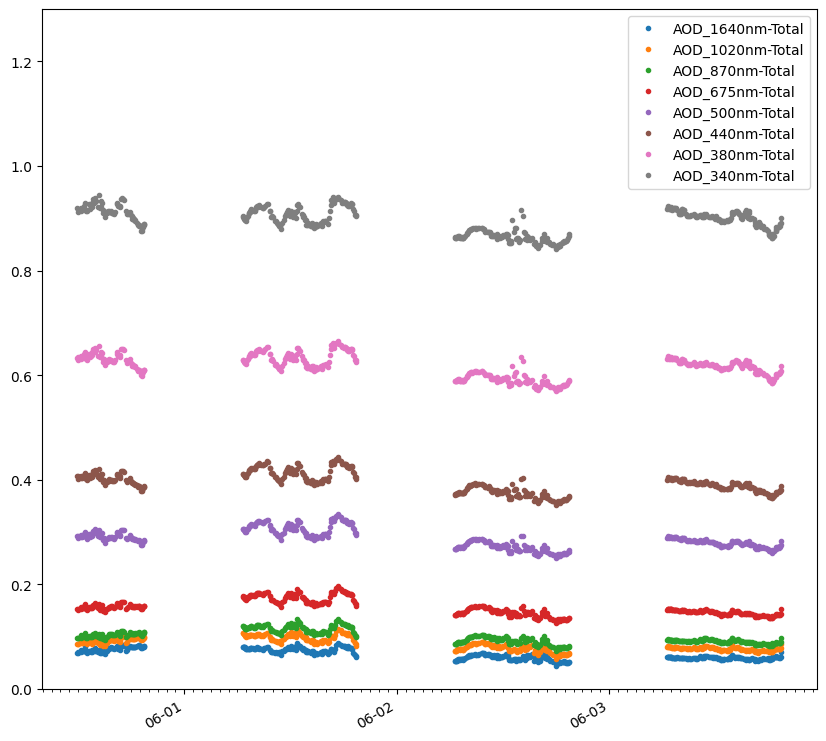

In [12]:
plt.figure(figsize=(10,10))   
#df[80:130]
for iWaveLength in df.columns[AODTotalColumns]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength])
        plt.plot(df[iWaveLength][0:494],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0,1.3)
plt.legend()
plt.show()


### There doesn't seem to be a big dependency on the wavelengths. So let's focus on the visible range only.

#### The reason that the minor and major locator tick does not line is up due to a bug since Python 3.5.2 where the HourLocator cannot do timezone correction. So its actually ploting those 3 hours tick marks in UTC. Due to the 7 hours time zone difference, it results in an 1 hour difference in the placement of the hourly tick mark relative to the Day (midnight) mark.

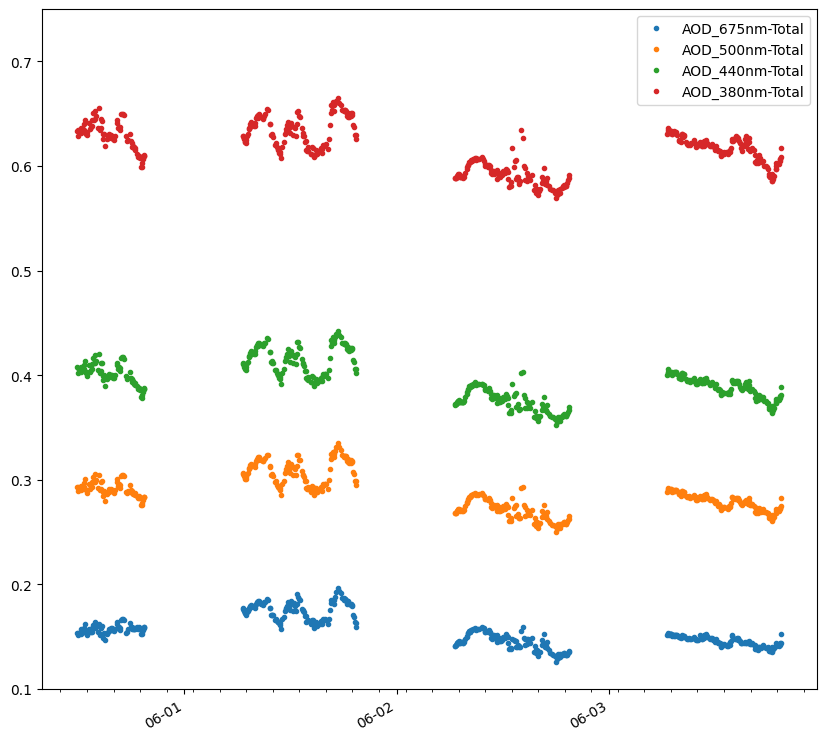

In [13]:
plt.figure(figsize=(10,10))  
# AODTotalColumns[5] is 675nm, AODTotalColumns[-1-1] is 380nm
for iWaveLength in df.columns[AODTotalColumns[5:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength])
        plt.plot(df[iWaveLength][0:494],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.ylim(0.1,0.75)
plt.legend()
plt.show()

### Now, let's pick a starting time and ending time instead of the DF's index to cut on the plot.

#### This plot has some interesting uptake on the AOD on June 6th and 7th.

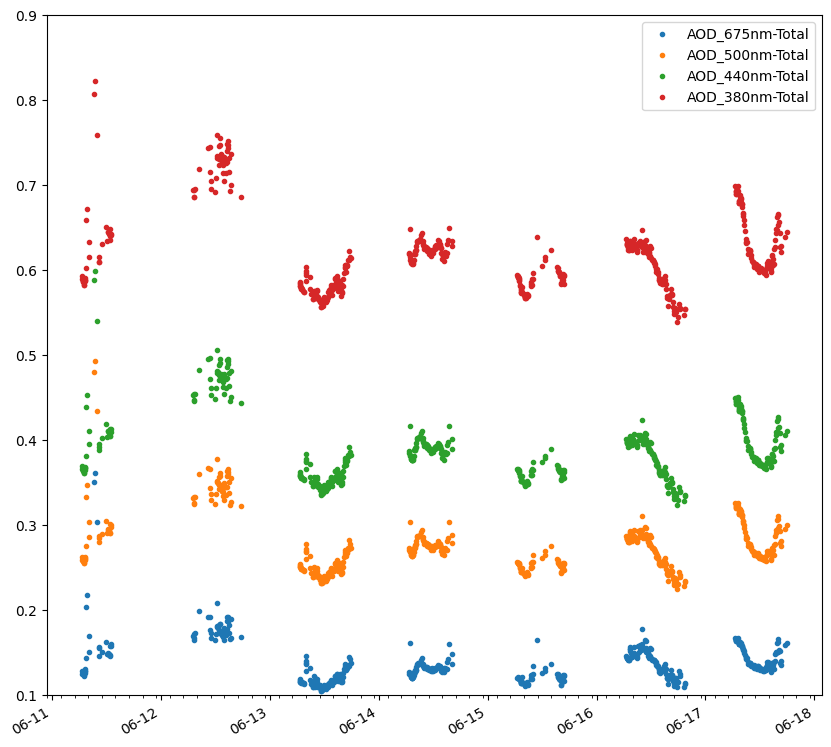

In [14]:
StartDate='2023-06-10'
EndDate='2023-06-17'

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[5:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength])
        plt.plot(df.loc[StartDate:EndDate,iWaveLength],'.',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.1,0.9)
plt.legend()
plt.show()

### Now let's do an hourly average of the data.

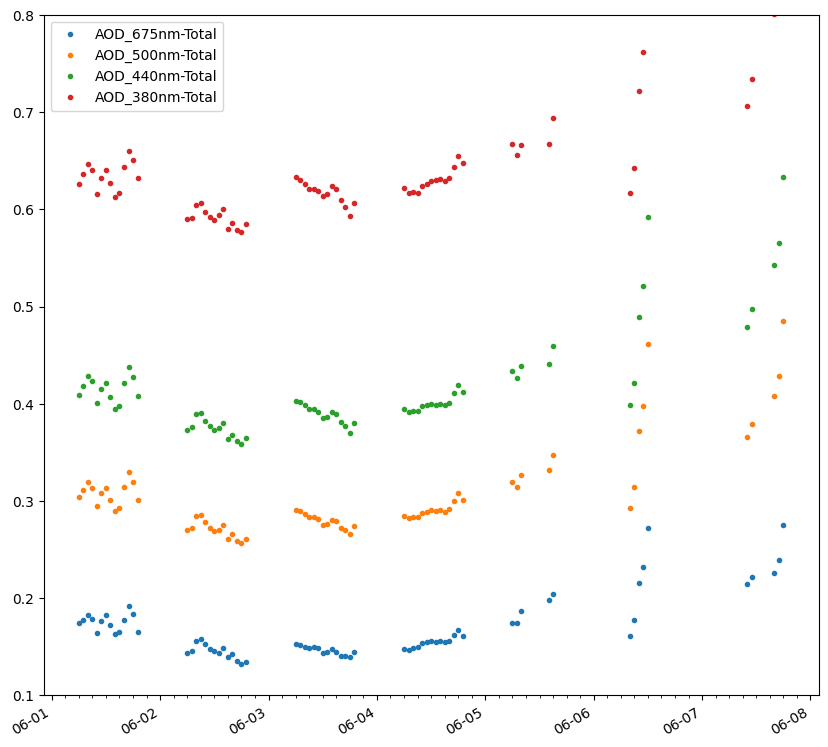

In [15]:
StartDate='2023-06-01'
EndDate='2023-06-07'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[5:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength)
        plt.plot(df.loc[StartDate:EndDate,iWaveLength].resample('1h').mean(),'.',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.1,0.8)
plt.legend()
plt.show()


### Repeat for 3 Hour Averaging.

#### Note that now we're at the point where we have 5 data points some days, 4 or 3 depending on how long the instrument takes data for. This is fairly annoying to fix and Anthony already did it so I will move on to Daily Averages.

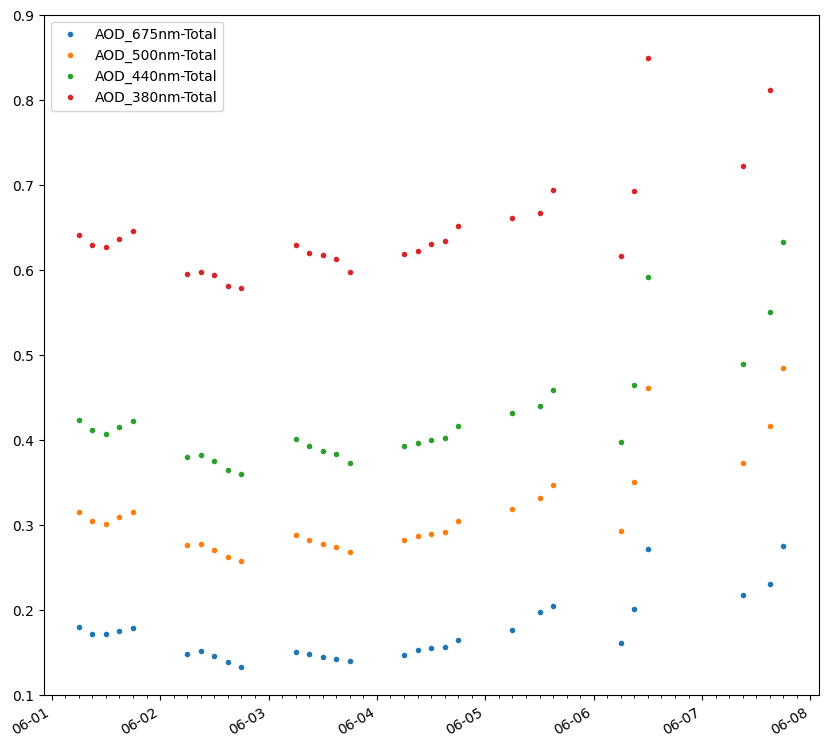

In [16]:
StartDate='2023-06-01 07:00:00'
EndDate='2023-06-07 19:00:00'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[3:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength)
        plt.plot(df.loc[StartDate:EndDate,iWaveLength].resample('3h', ).mean(),'.',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.1,0.9)
plt.legend()
plt.show()


### Plotting the Daily averages for the entire 1.3 Months.

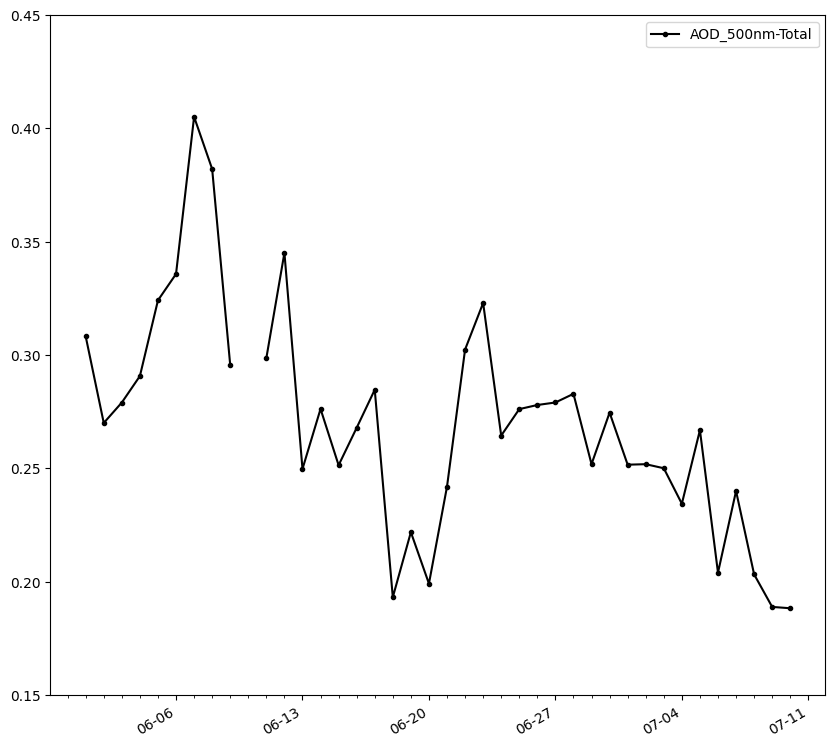

In [17]:
StartDate='2023-06-01'
EndDate='2023-07-10'

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[6:-5]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength)
        plt.plot(df.loc[StartDate:EndDate,iWaveLength].resample('1D', ).mean(),'.-k',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.15,0.45)
plt.legend()
plt.show()


### Let's look at the Wind Data for June 2023, starting with the magnitude only.

In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

windfile = 'Wind_Data/Modesto_Wind_2023.csv'

# Load Files 
Wdf = pd.read_csv(windfile, parse_dates={'datetime':[1]})
Wdf.head()

datetime_utc=pd.to_datetime(Wdf["datetime"], format='%d-%m-%Y %H:%M:%S')
#print(datetime_pac.head())
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
#print(datetime_pac.head())

Wdf.set_index(datetime_pac, inplace = True)
#print(Wdf.head())  
print(Wdf['WND'].str.split(pat=',', expand= True))

                             0  1  2     3  4
datetime                                     
2022-12-31 16:15:00-08:00  260  5  N  0046  5
2022-12-31 16:22:00-08:00  260  5  N  0041  5
2022-12-31 16:27:00-08:00  260  5  N  0051  5
2022-12-31 16:34:00-08:00  270  5  N  0057  5
2022-12-31 16:53:00-08:00  260  5  N  0057  5
...                        ... .. ..   ... ..
2023-07-09 19:53:00-07:00  330  5  N  0051  5
2023-07-09 20:53:00-07:00  330  5  N  0051  5
2023-07-09 21:53:00-07:00  330  5  N  0051  5
2023-07-09 22:53:00-07:00  330  5  N  0046  5
2023-07-09 23:53:00-07:00  330  5  N  0041  5

[5480 rows x 5 columns]


### Let's start with 1 hour averaging for the week of June 1st to June 8th (Getting one more day before and after to see the trend after the week).

#### For May 31st to June 4th. The AOD seems to trend down in the afternoon. The wind usually picks up to about 6-7 m/s at about 3PM also.

#### For June 5th, we have a upward trend on the AOD even though the wind is picking up at the same time.

### For June 5th, 6th and 7th. There seems to be unreliable data. This is worth looking at one its own.

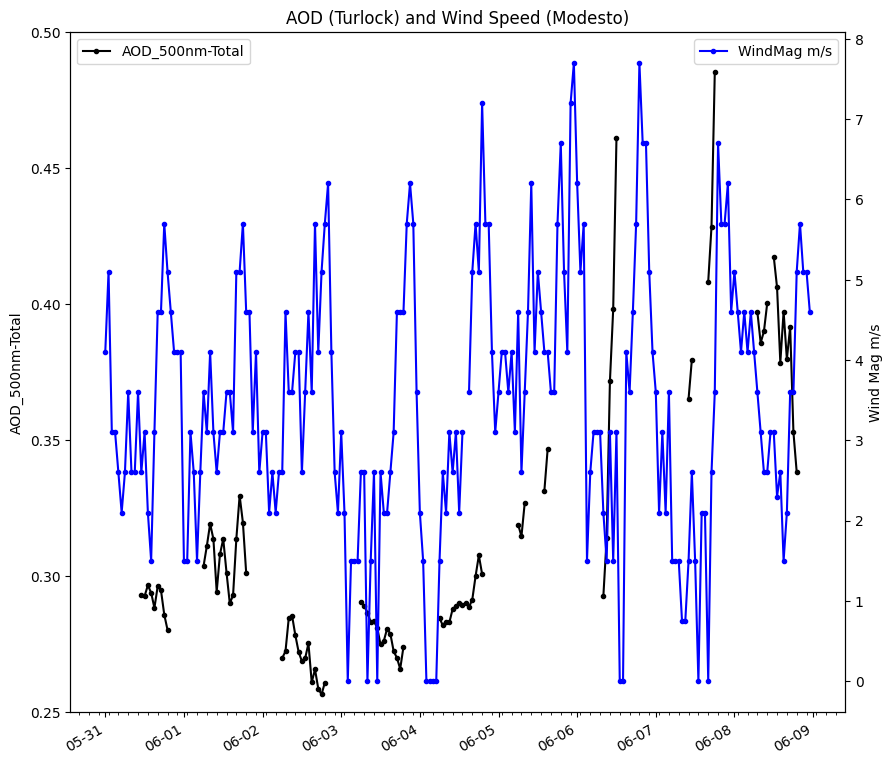

In [19]:

StartDate='2023-05-31 00:00:00'
EndDate='2023-06-08 23:59:59'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()

plt.figure(figsize=(10,10))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.title("AOD (Turlock) and Wind Speed (Modesto)")
plt.ylim(0.25,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot((WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)).resample('1h').mean(),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()

### Let's look at the data from June 5th to 7 on its own.

#### Can't really see much with the 1h resampling. Let's remove the resampling...

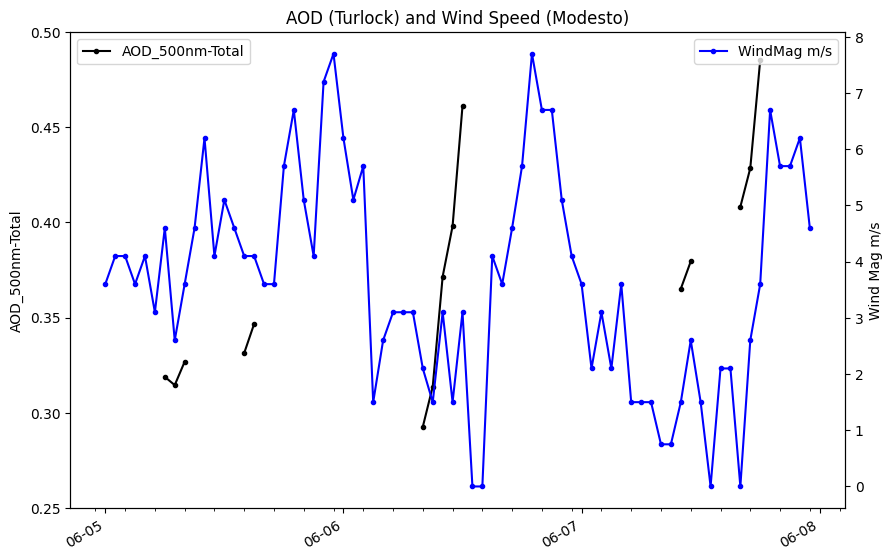

In [20]:
#print(df['WND'].str.split(pat=',', expand= True)[3])
StartDate='2023-06-05 00:00:00'
EndDate='2023-06-07 23:59:59'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()

plt.figure(figsize=(10,7))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.title("AOD (Turlock) and Wind Speed (Modesto)")
plt.ylim(0.25,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot((WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)).resample('1h').mean(),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()

### Let's look at the data from June 5th to 7 on its own without resampling


#### It looks like there are just time when the AOD data is missing
#### Its the same for the other wavelengths also.

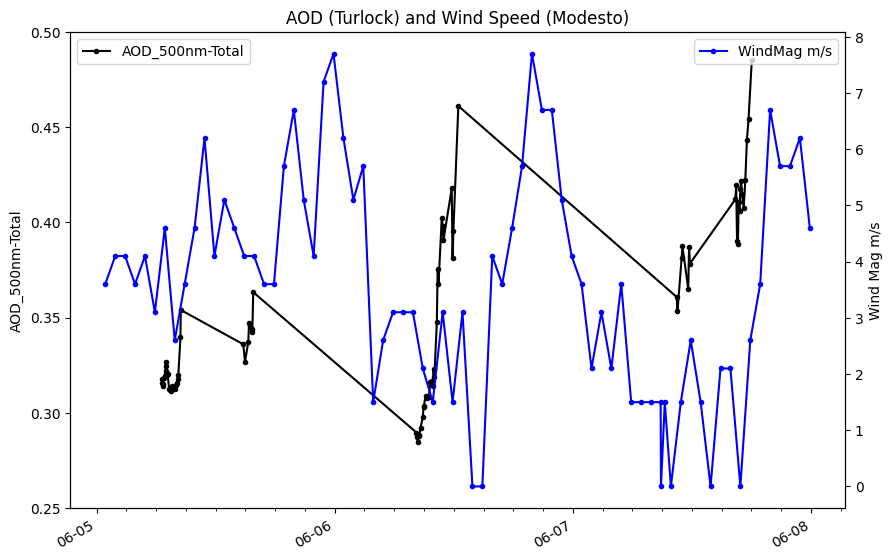

In [21]:
#print(df['WND'].str.split(pat=',', expand= True)[3])
StartDate='2023-06-05 00:00:00'
EndDate='2023-06-07 23:59:59'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()

plt.figure(figsize=(10,7))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'],'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.title("AOD (Turlock) and Wind Speed (Modesto)")
plt.ylim(0.25,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot(WNDdf[3].loc[StartDate:EndDate].astype(float).div(10),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()

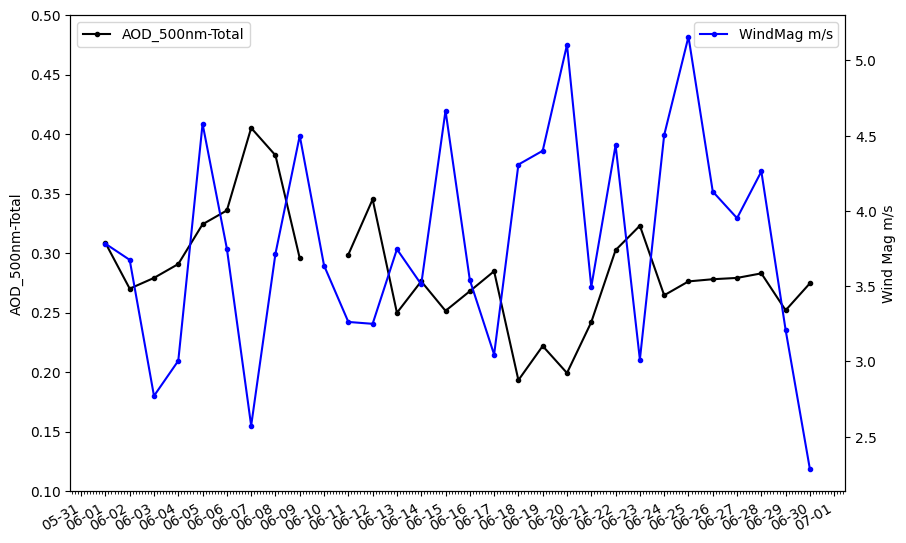

In [22]:
#print(df['WND'].str.split(pat=',', expand= True)[3])
StartDate='2023-06-01 07:00:00'
EndDate='2023-06-30 23:00:00'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())


WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()


plt.figure(figsize=(10,7))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1D').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.ylim(0.1,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot((WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)).resample('1D').mean(),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()